<a href="https://colab.research.google.com/github/basileplus/sac-rsa/blob/main/RSA_SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
from IPython.display import display, clear_output
from plotly.subplots import make_subplots
import torch.optim as optim
import torch.nn.functional as F

# Data

First, we create the data :
- a truth matrix $T\in M_{U\times M}(\mathbb{R})$ composed of 0 and 1
- a prior knowledge matrix $P\in M_{M}(\mathbb{R})$

where $U$ is the number of utterances and $M$ is the number of meanings.

In [2]:
# Define the probability of obtaining 1s
prob = 0.5
shape = [5,5]
# Create a tensor filled with the probability value
prob_tensor = torch.full(shape, prob)
# Generate the tensor using the Bernoulli distribution
T = torch.bernoulli(prob_tensor)

# Define the prior probability of each object
P = torch.ones(shape[0])/shape[0]

Next we need to clean this data to exclude lines and rows of zero with the following function

In [3]:
def clean_data(T, P):
    # Check for rows of zeros
    row_zeros = (T == 0).all(dim=1)
    if row_zeros.any():
        print("Warning: The T contains rows of zeros.")
        print(f"Rows to be removed: {torch.nonzero(row_zeros).squeeze().tolist()}")
        T = T[~row_zeros]
        #P = P[~row_zeros]

    # Check for columns of zeros
    col_zeros = (T == 0).all(dim=0)
    if col_zeros.any():
        print("Warning: The T contains columns of zeros.")
        print(f"Columns to be removed: {torch.nonzero(col_zeros).squeeze().tolist()}")
        T = T[:, ~col_zeros]
        P = P[~col_zeros]

    return T, P

In [4]:
T,P = clean_data(T, P)
print(T)
print(P)

tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1.]])
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


Note that we can still have indistinguishable meanings, i.e. two meanings that possess the same truth values for all utterances.

# Soft Actor Critic (SAC)

We are going to implement RSA as a soft actor critic alogrithm. SAC is composed of :
- An _actor_ that learn the policy $\pi(a|s)$ giving the probability of taking an action $a$ given a state $s$
- A _critic_ that learn the value function $Q(s,a)$ giving the expected return of taking an action $a$ in a state $s$

In our case, **the state $s$ is the meaning $m$ to transmit and the action $a$ is sending a utterance $u$**.

| RSA | SAC |
| --- | --- |
| Speaker | Actor |
| Listener | Critic |
| $u$ | $a$ |
| $m$ | $s$ |

Both models are going to be parametrized by discrete tensor $\theta_A \in M_{U\times M}(\mathbb{R})$ and $\theta_C \in M_{U\times M}(\mathbb{R})$.

The critic represent speaker's understanding of the listener. $\theta_C$ is going to describe the estimated probability of the listener to understand the meaning $m$ given the utterance $u$.



## Critic policy

We will use the Boltzmann policy to represent the listener estimation of the listener :
$$
\pi_{\theta_C}(s|a) = \frac{e^{\theta_C}(s,a)}{\sum_{s'}e^{\theta_C}(s',a)}
$$

Note that we switched $s$ and $a$ because $s \leftrightarrow m$ and $a \leftrightarrow u$.

/!\ This expression is here for comprehension only. In SAC there is only one policy : the actor policy. But as we are going need $L(m|u) \leftrightarrow \pi_{\theta_C}(s|a)$ to compute the value $Q(a,s)$ of a $a,s$ pair, we will indereclty use the "critic policy".

## Actor policy

In the other hand, the actor policy is straightforward :
$$
\pi_{\theta_A}(a|s) = \frac{e^{\theta_A}(a,s)}{\sum_{a'}e^{\theta_A}(a',s)}
$$

## Inintialization of the parameters

We want to initialize actor and critic according to the truth matrix $T$ so that they only use true utterances to describe meanings. **We do not want the actor to violate the lexicon**. Given the policy $\pi_{\theta_A}$ we can chose :
$$
(\theta_A)_{a,s} =  \left\{
    \begin{matrix}
        -\infty \text{ if (a,s) is false} \\
        1 \text{ otherwise}
 \end{matrix} \right.
$$
In practice, we will take $-100$ instead of $-\infty$.

In [5]:
T

tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1.]])

In [6]:
def init_thetas(T):
    theta_A = torch.where(T==0, -100, T)
    theta_A = torch.where(T==1, 0, theta_A)
    theta_C = torch.where(T==0, -100, T)
    theta_C = torch.where(T==1, 0, theta_C)
    theta_A.requires_grad = True
    theta_C.requires_grad = True
    return theta_A, theta_C

theta_A, theta_C = init_thetas(T)
print(theta_A, theta_C)

tensor([[   0.,    0.,    0., -100.,    0.],
        [   0.,    0.,    0., -100., -100.],
        [-100.,    0., -100., -100.,    0.],
        [-100., -100., -100.,    0.,    0.],
        [-100.,    0.,    0.,    0.,    0.]], requires_grad=True) tensor([[   0.,    0.,    0., -100.,    0.],
        [   0.,    0.,    0., -100., -100.],
        [-100.,    0., -100., -100.,    0.],
        [-100., -100., -100.,    0.,    0.],
        [-100.,    0.,    0.,    0.,    0.]], requires_grad=True)


# Actor

Let's begin by defining the actor. The actor is defined by its parameters $\theta_A$ and its policy $\pi_{\theta_A}$. Often in SAC a neural network is used for both actor and critic, but for simplicity we used here a simple Boltzmann policy.

The actor need to be able to :
- compute its probability distribution $\pi_{\theta_A}(a|s)$ (here we use discrete distribution so can be put in a tensor)
- sample an action given a state and a policy
- compute its loss function

## Compute the policy

The actor samples an action given a tensor of logits (unnormalized parameters).
Logits are the events log probabilities. This is why we initialized $\theta$ with $-100$ and $0$.

We will use the distribution class created by PyTorch to compute the policy. Our distribution is a categorical distribution. Doc can be found [here](https://pytorch.org/docs/stable/distributions.html#torch.distributions.categorical.Categorical).

In [7]:
from torch.distributions import Categorical

pi_a = Categorical(logits = torch.tensor([-100, 0, 0, -100]))
pi_a.probs

tensor([1.9618e-44, 5.0000e-01, 5.0000e-01, 1.9618e-44])

This probability distribution is for a given state $s$, so we need to create to functions :
- one to compute the policy for every states given parameters $\theta_A$
- one to sample an action given a state

In [8]:
def compute_pol(theta):
    distris = [Categorical(logits = theta[:,i].contiguous()) for i in range(theta.shape[1])]
    probs = [Categorical(logits = theta[:,i].contiguous()).probs for i in range(theta.shape[1])]
    probs = torch.cat([prob.unsqueeze(0).t() for prob in probs], dim=1)
    return distris, probs

def sample_action(distris, a):
    return distris[a].sample()


print("probabilities : ",compute_pol(theta_A)[1])
print("sampled action for state 0 : ",sample_action(compute_pol(theta_A)[0], 0))

probabilities :  tensor([[5.0000e-01, 2.5000e-01, 3.3333e-01, 1.9618e-44, 2.5000e-01],
        [5.0000e-01, 2.5000e-01, 3.3333e-01, 1.9618e-44, 9.8091e-45],
        [1.9618e-44, 2.5000e-01, 1.2612e-44, 1.9618e-44, 2.5000e-01],
        [1.9618e-44, 9.8091e-45, 1.2612e-44, 5.0000e-01, 2.5000e-01],
        [1.9618e-44, 2.5000e-01, 3.3333e-01, 5.0000e-01, 2.5000e-01]],
       grad_fn=<CatBackward0>)
sampled action for state 0 :  tensor(1)


## Compute the loss

Now we can compute the loss of the actor that we defined as :
\begin{align*}
\mathcal{L}_{\text{actor}} &=- \mathbb{E}_{s\sim P}[\mathbb{E}_{a\sim \pi_{\theta_A}(a|s)}[Q_{\theta_C}(a,s) - \underbrace{\log(\pi_{\theta_A}(a|s))}_\text{entropy regularization}]]\\
&= -\sum_{s}P(s)\left(\sum_{a}\pi_{\theta_A}(a|s)Q_{\theta_C}(a,s) + H_s(\pi_{\theta_A})\right)
\end{align*}

Where $H_s(\pi_{\theta_A})$ is the entropy of the policy $\pi_{\theta_A}$ given the state $s$.
As input we need :
- the policy $\pi_{\theta_A}(a|s)$
- the value $Q_{\theta_C}(a,s)$ of the pair : this will be given later by the critic
- the prior knowledge tensor $P$


In [9]:
def compute_loss(distris, probs, Q, P):
    entropies = torch.stack([dist.entropy() for dist in distris])
    print(entropies)
    return -torch.sum(P * (torch.sum(probs * Q, dim=0) + entropies))


distris, probs = compute_pol(theta_A)
Q, _ = clean_data(T,P) # for exemple
print(compute_loss(distris, probs, Q, P))

tensor([0.6931, 1.3863, 1.0986, 0.6931, 1.3863], grad_fn=<StackBackward0>)
tensor(-2.0515, grad_fn=<NegBackward0>)


In [10]:
print(compute_loss(distris, probs, Q, P))

tensor([0.6931, 1.3863, 1.0986, 0.6931, 1.3863], grad_fn=<StackBackward0>)
tensor(-2.0515, grad_fn=<NegBackward0>)


## Update the parameters

Finally we need to compute the gradient of that loss to update the parameters $\theta_A$ using classic stochastic gradient descent (SGD).

In [11]:
def update_theta(theta, Q, P, lr=0.01):
    optimizer = torch.optim.SGD([theta], lr=lr)
    optimizer.zero_grad()
    distris, probs = compute_pol(theta)
    loss = compute_loss(distris, probs, Q, P)
    loss.backward()

    optimizer.step()


In [12]:
print("theta before : ",theta_A)
update_theta(theta_A, Q, P,lr=1)
print("theta after : ",theta_A)

theta before :  tensor([[   0.,    0.,    0., -100.,    0.],
        [   0.,    0.,    0., -100., -100.],
        [-100.,    0., -100., -100.,    0.],
        [-100., -100., -100.,    0.,    0.],
        [-100.,    0.,    0.,    0.,    0.]], requires_grad=True)
tensor([0.6931, 1.3863, 1.0986, 0.6931, 1.3863], grad_fn=<StackBackward0>)
theta after :  tensor([[ 5.6052e-45,  0.0000e+00, -7.4506e-09, -1.0000e+02,  0.0000e+00],
        [ 5.6052e-45,  0.0000e+00, -7.4506e-09, -1.0000e+02, -1.0000e+02],
        [-1.0000e+02,  0.0000e+00, -1.0000e+02, -1.0000e+02,  0.0000e+00],
        [-1.0000e+02, -1.0000e+02, -1.0000e+02,  5.6052e-45,  0.0000e+00],
        [-1.0000e+02,  0.0000e+00, -7.4506e-09,  5.6052e-45,  0.0000e+00]],
       requires_grad=True)


$\theta_A$ has effectively been updated

In [13]:
compute_pol(theta_A)

([Categorical(logits: torch.Size([5])),
  Categorical(logits: torch.Size([5])),
  Categorical(logits: torch.Size([5])),
  Categorical(logits: torch.Size([5])),
  Categorical(logits: torch.Size([5]))],
 tensor([[5.0000e-01, 2.5000e-01, 3.3333e-01, 1.9618e-44, 2.5000e-01],
         [5.0000e-01, 2.5000e-01, 3.3333e-01, 1.9618e-44, 9.8091e-45],
         [1.9618e-44, 2.5000e-01, 1.2612e-44, 1.9618e-44, 2.5000e-01],
         [1.9618e-44, 9.8091e-45, 1.2612e-44, 5.0000e-01, 2.5000e-01],
         [1.9618e-44, 2.5000e-01, 3.3333e-01, 5.0000e-01, 2.5000e-01]],
        grad_fn=<CatBackward0>))

However the policy $\pi_{\theta_A}$ does not seem to have been updated. This is because we used a $Q=T$ so the same importance is given to every true utterance. This way the policy does not change. Let's see what happens with a different $Q$.

In [14]:
Q = F.normalize(T, dim=1, p=1)
print("Q = ", Q)
update_theta(theta_A, Q, P, lr=1)
print("policy = ", compute_pol(theta_A)[1], "\n Truth matrix T = ",T)

Q =  tensor([[0.2500, 0.2500, 0.2500, 0.0000, 0.2500],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 0.2500, 0.2500, 0.2500, 0.2500]])
tensor([0.6931, 1.3863, 1.0986, 0.6931, 1.3863], grad_fn=<StackBackward0>)
policy =  tensor([[4.9792e-01, 2.4896e-01, 3.3272e-01, 1.8217e-44, 2.4844e-01],
        [5.0208e-01, 2.5000e-01, 3.3457e-01, 1.8217e-44, 9.8091e-45],
        [1.8217e-44, 2.5209e-01, 1.2612e-44, 1.8217e-44, 2.5156e-01],
        [1.8217e-44, 9.8091e-45, 1.2612e-44, 5.0625e-01, 2.5156e-01],
        [1.8217e-44, 2.4896e-01, 3.3272e-01, 4.9375e-01, 2.4844e-01]],
       grad_fn=<CatBackward0>) 
 Truth matrix T =  tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1.]])


Now the policy has slightly changed. We can also notice that it encouraged the actor to use the most informative utterances.

Perfect. Now we can define an actor class to store those methods.

The actor will require the following arguments :
- initial parameter $\theta_A^0$
- action space $U$ : utterances space represented by an index $a \in \{0,1,...,U-1\}$
- state space $M$ : meanings space represented by an index $s \in \{0,1,...,M-1\}$
- critic model : in our case of SAC, to compute the loss function of the actor we need the critic model

In [15]:
class Actor:
    def __init__(self, theta_init, lr=0.01):
        self.theta = theta_init
        self.distris, self.probs = torch.tensor(0), torch.tensor(0)
        self.loss = torch.tensor(0)
        self.optimizer = torch.optim.SGD([self.theta], lr=lr)
        self.entropy_term = torch.tensor(0)

    def update_pol(self):
        distris = [Categorical(logits = self.theta[:,i].contiguous()) for i in range(self.theta.shape[1])]
        probs = [Categorical(logits = self.theta[:,i].contiguous()).probs for i in range(self.theta.shape[1])]
        probs = torch.cat([prob.unsqueeze(0).t() for prob in probs], dim=1)
        self.distris, self.probs = distris, probs

    def sample_action(self, action):
        return self.distris[action].sample()

    def update_loss(self, Q, P):
        """
        inputs :
        Q values of (a,s) pairs
        P : prior probability of each meaning (or state)
        """
        entropies = torch.stack([dist.entropy() for dist in self.distris])
        entropy_term = torch.sum(P*entropies)
        loss = -torch.sum(P * (torch.sum(self.probs * Q, dim=0)) + entropy_term)
        self.entropy_term = entropy_term
        self.loss = loss


    def update_theta(self):
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()


To test the actor we can run one loop of the training process.

In [16]:
Q = F.normalize(T, dim=1, p=1)

theta_A,_ = init_thetas(T) # reset theta_A
actor = Actor(theta_init=theta_A,lr=1)
actor.update_pol()
actor.update_loss(Q,P)
#print("actor probs before update : ",actor.probs)
print("actor loss before update : ",actor.loss)
actor.update_theta()
actor.update_pol()
actor.update_loss(Q,P)
#print("actor probs after update : ",actor.probs)
print("actor loss after update : ",actor.loss)

actor loss before update :  tensor(-5.5881, grad_fn=<NegBackward0>)
actor loss after update :  tensor(-5.5886, grad_fn=<NegBackward0>)


# Critic

The critic is defined by its parameters $\theta_C$. The critic need to be able to :
- compute its value function $Q_{\theta_C}(a,s)$
- compute its loss function $\mathcal{L}_{\text{critic}}$
- update its parameters $\theta_C$

For visualization purpose, we will also compute the policy $\pi_{\theta_C}(s|a)$ even though it is not used in Soft Actor Critic.

## Compute value function

Its value function is defined as :
$$
Q_{\theta_C}(a,s) = \alpha * \log\left(\frac{\exp(\theta_C(a,s))}{\sum_{s'}\exp(\theta_C(a,s'))}\right)
$$

Where $\alpha$ is a hyperparameter appearing in classic RSA : $S(u|m)\propto \exp(\alpha V_L(u,m))$.

In [17]:
def compute_Q(theta, alpha=1):
    Q = alpha*(torch.log(torch.softmax(theta,dim=1)))
    return Q
print(compute_Q(theta_C))

tensor([[  -1.3863,   -1.3863,   -1.3863, -101.3330,   -1.3863],
        [  -1.0986,   -1.0986,   -1.0986, -101.0817, -101.0817],
        [-100.6399,   -0.6931, -100.6399, -100.6399,   -0.6931],
        [-100.6399, -100.6399, -100.6399,   -0.6931,   -0.6931],
        [-101.3330,   -1.3863,   -1.3863,   -1.3863,   -1.3863]],
       grad_fn=<MulBackward0>)


## Loss function

Now the loss function, defined as :
$$
\mathcal{L}_{\text{critic}} = -\sum_{s}P(s)\left(\sum_{a}\pi_{\theta_A}(a|s)Q_{\theta_C}(a,s) + H_s(\pi_{\theta_A})\right)
$$

In [18]:
def compute_loss(probs,Q,P):
    loss = -torch.sum(P * (torch.sum(probs * Q, dim=0)))
    return loss

compute_loss(actor.probs, compute_Q(theta_C), P)

tensor(1.1489, grad_fn=<NegBackward0>)

## $\theta$ update

We can now update parameters $\theta_C$ using SGD.

In [19]:
def update_theta(theta, probs, Q, P, lr=0.01):
    optimizer = torch.optim.SGD([theta], lr=lr)
    optimizer.zero_grad()
    loss = compute_loss(probs, Q, P)
    loss.backward()
    optimizer.step()
    return theta

_, theta_C = init_thetas(T)
actor = Actor(theta_init=theta_C,lr=1)
actor.update_pol()
probs = actor.probs
Q = compute_Q(theta_C)
print("theta_C before update : ", theta_C)
theta_C = update_theta(theta_C, probs, Q, P)
print("theta_C after update : ", theta_C)

theta_C before update :  tensor([[   0.,    0.,    0., -100.,    0.],
        [   0.,    0.,    0., -100., -100.],
        [-100.,    0., -100., -100.,    0.],
        [-100., -100., -100.,    0.,    0.],
        [-100.,    0.,    0.,    0.,    0.]], requires_grad=True)
theta_C after update :  tensor([[ 1.8949e-04, -2.8927e-04, -6.3929e-05, -1.0000e+02, -3.3995e-04],
        [ 4.2162e-04, -2.0098e-04,  7.2303e-05, -1.0000e+02, -1.0000e+02],
        [-1.0000e+02,  2.2397e-04, -1.0000e+02, -1.0000e+02,  1.7329e-04],
        [-1.0000e+02, -1.0000e+02, -1.0000e+02,  5.9657e-04, -7.6713e-05],
        [-1.0000e+02, -2.8927e-04, -6.3929e-05, -1.3240e-05, -3.3995e-04]],
       requires_grad=True)


## Policy

For better understanding, we can compute the policy $\pi_{\theta_C}(s|a)$ with care to not switch $s$ and $a$ in the formula.

In [20]:
def compute_pol(theta):
    distris = [Categorical(logits = theta[i,:].contiguous()) for i in range(theta.shape[0])]
    probs = [Categorical(logits = theta[i,:].contiguous()).probs for i in range(theta.shape[0])]
    probs = torch.cat([prob.unsqueeze(0) for prob in probs], dim=0)
    return distris, probs

distris, probs = compute_pol(theta_C)
print("probs = ", probs)

probs =  tensor([[2.5008e-01, 2.4996e-01, 2.5002e-01, 9.8091e-45, 2.4995e-01],
        [3.3344e-01, 3.3323e-01, 3.3332e-01, 1.2612e-44, 1.2612e-44],
        [1.9618e-44, 5.0001e-01, 1.9618e-44, 1.9618e-44, 4.9999e-01],
        [1.9618e-44, 1.9618e-44, 1.9618e-44, 5.0017e-01, 4.9983e-01],
        [9.8091e-45, 2.4997e-01, 2.5003e-01, 2.5004e-01, 2.4996e-01]],
       grad_fn=<CatBackward0>)


A tensor is said _contiguous_ when its data is stored in a contiguous block of memory : stored sequentially in memory without any gaps.

The ``.contiguous`` method allow the tensor to be contiguous. Slicing may cause the tensor to be non contiguous and some pyTorch operations require the tensor to be contiguous. When the ``grad_fn`` of the computational graph blocks at ``AsStridedBackward0`` it typically reference to an issue with slicing operation.

We can finally put those function in a class to store them.

In [21]:
class Critic:
    def __init__(self, theta_init, alpha=1, lr=0.01):
        self.theta = theta_init
        self.Q = torch.tensor(0)
        self.alpha = alpha
        self.optimizer = torch.optim.SGD([self.theta], lr=lr)
        self.loss = torch.tensor(0)
        self.probs = torch.tensor(0)
        self.distris = torch.tensor(0)

    def update_Q(self):
        self.Q = self.alpha*(torch.log(torch.softmax(self.theta,dim=1)))

    def update_loss(self, probs, P):
        self.loss = -torch.sum(P * (torch.sum(probs * self.Q, dim=0) - probs * torch.log(probs)))

    def update_theta(self,lr=0.01):
        self.optimizer = torch.optim.SGD([self.theta], lr=lr)
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

    def update_pol(self):
        distris = [Categorical(logits = self.theta[i,:].contiguous()) for i in range(self.theta.shape[0])]
        probs = [Categorical(logits = self.theta[i,:].contiguous()).probs for i in range(self.theta.shape[0])]
        self.probs = torch.cat([prob.unsqueeze(0) for prob in probs], dim=0)
        self.distris = distris

In [22]:
torch.autograd.set_detect_anomaly(True)

In [23]:
print(T)
print("----------BEFORE UPDATE----------")
theta_A, theta_C = init_thetas(T)
actor = Actor(theta_A, lr=1)
critic = Critic(theta_C, lr=1)
actor.update_pol()
critic.update_Q()
probs = actor.probs.clone()
critic.update_loss(probs, P)
actor.update_loss(critic.Q, P)
print("critic loss : ", critic.loss)
print("actor loss + e : ", actor.loss + actor.entropy_term)
print("entropy_term = ",actor.entropy_term)
print("-----------AFTER UPDATE-----------")
critic.update_theta()
#actor.update_theta()
actor.update_pol()
critic.update_Q()
critic.update_loss(probs, P)
actor.update_loss(critic.Q, P)
print("critic loss : ", critic.loss)
print("entropy_term = ",actor.entropy_term)

tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1.]])
----------BEFORE UPDATE----------
critic loss :  tensor(4.7019, grad_fn=<NegBackward0>)
actor loss + e :  tensor(-3.0553, grad_fn=<AddBackward0>)
entropy_term =  tensor(1.0515, grad_fn=<SumBackward0>)
-----------AFTER UPDATE-----------
critic loss :  tensor(4.7004, grad_fn=<NegBackward0>)
entropy_term =  tensor(1.0515, grad_fn=<SumBackward0>)


And we could continue to train the critic as long as we execute the instruction in the following order :
1. ``critic.update_Q()``
2. ``critic.compute_loss()``
3. ``critic.update_theta()``

In [24]:
critic.update_Q()
critic.update_loss(probs, P)
actor.update_loss(critic.Q, P)

This verifies that there is no problem with the computational graph being destroyed and not fully reconstructed. But one may notice that we cheated by fixing
```python
probs = actor.probs.clone()
```
This way we do not backpropagate through the actor when updating the critic. If we used ``actor.probs`` insteand of ``probs``, the computational graph would be destroyed once the actor as been backpropagated and we could not backpropagate through the critic because the computational graph would have already been destroyed.

The way we implemented the SAC is not correct and we should do a single backpropagation through every parameters instead of two separate backpropagation, and this is because **actor and critic are not independent**.

The error : "Trying to backward through the graph a second time"occurs after using ``.backward()`` because the computational graph has been destroyed. We need to reconstruct a new one to use ``.backward()`` again.

# Soft Actor Critic

Now that we have defined the actor and the critic, we can implement the Soft Actor Critic algorithm. It will be pretty straightforward as we already already coded everything we need.

We just want to keep in mind that actor and critic are two parts of the same SAC model so we create the simple SAC class.

We also have to take care of the above issue when backpropagating through the actor and the critic. For this reason we will use the ``.detach()`` method to detach the shared tensors from the computational graph. The shared tensors are $Q_{\theta_C}$ and $\pi_{\theta_A}$.

In [25]:
class SAC:
    def __init__(self, theta_A, theta_C, config):
        self.actor = Actor(theta_A, lr=config.lr_A)
        self.critic = Critic(theta_C, alpha=config.alpha, lr=config.lr_C)

    def sample_action(self, action):
        return self.actor.sample_action(action)

    def update(self, P):
        self.actor.update_pol()
        self.critic.update_pol()
        self.critic.update_Q()
        self.actor.update_loss(self.critic.Q.detach(), P)
        self.critic.update_loss(self.actor.probs.detach(), P)
        self.actor.update_theta()
        self.critic.update_theta()
        self.critic.update_pol()

We also define a simple method class to store model parameters.

In [26]:
class Config:
    def __init__(self, num_episodes=1000, lr_A=0.01, lr_C=0.01, alpha=1, env_name='DefaultEnv'):
        self.num_episodes = num_episodes
        self.lr_A = lr_A
        self.lr_C = lr_C
        self.alpha = alpha
        self.env_name = env_name

# Environment

In Reinforcement Learning, some signals are sent by the environment the agent is learning from. In our case, the environment is the listener.

This environment could for instance be the real listener receiving speaker messages. As in RSA we only use the approximated listener, we could tell our environment to perfetcly mimic critic behavour.

The environment is mainly responsible for :
- sending a starting state
- sending a reward
- giving the next state (guessed state for instance)

As we do not know how we want to use the RSA, we will keep it simple and only implement the first two points.
The environment should take as argument a listener model, but here we will use this class differently.

In [27]:
class Environment:
    def __init__(self, P, T):
        self.P = P
        self.T = T
        self.theta_A, self.theta_C = self.init_thetas(self.T)

    def init_thetas(self, T):
        theta_A = torch.where(T==0, -100, T)
        theta_A = torch.where(T==1, 0, theta_A)
        theta_C = torch.where(T==0, -100, T)
        theta_C = torch.where(T==1, 0, theta_C)
        theta_A.requires_grad = True
        theta_C.requires_grad = True
        return theta_A, theta_C

    def get_reward(self, action, listener): # We put an action as in any classic RL case, reward depends on the action
        return -listener.loss

    def step(self, listener, state, action):
        reward = -listener.loss
        next_state = None
        return next_state, reward

    def reset(self):
        return torch.multinomial(self.P, num_samples=1) # sample initial state


In [28]:
env = Environment(P,T)
env.get_reward(0, critic)
env.reset()
print(env.step(critic, None, None))

(None, tensor(-4.7004, grad_fn=<NegBackward0>))


Let think about this ``get_reward()`` function :
```python
    def get_reward(self, action, listener):
        return -listener.loss
```
Here we are in a special case where we will suppose that **the listener is the critic**. So our ``listener`` argument will be the critic model. In reality SAC is made for our speaker to have a representation, an estimation of the real speaker. This estimation is its critic. In the environment we have the real listener, possibly different from the critic.

We can see that as the speaker talking to himself, or to the listener as he imagine it, to prepare its future messages.
Another possible explanation is that both the speaker and real listener think exactly the same way.

In real RL we would adjust the ``get_reward`` function and modify ``actor.update_loss`` function to compute a loss using the environment reward. For instance Advantage Actor Critic (A2C) algorithm uses the advantage defined as $A^\pi\left(s_t, a_t\right)=Q^\pi\left(s_t, a_t\right)-V^\pi\left(s_t\right)$. Most importantly $Q^\pi\left(s_t, a_t\right)$ and $V^\pi\left(s_t\right)$ are built using environment rewards. Here we computed those values using the critic as if it was the real listener (=environment).

For more information on how is computed a real Soft Actor Critic algorithm, you can check this [book](https://books.google.ca/books/about/Foundations_of_Deep_Reinforcement_Learni.html?id=QVA8ugEACAAJ&redir_esc=y) or the [original paper](https://arxiv.org/abs/1801.01290).

For now we will keep an _incomplete_ environment but keep in mind that if we wanted to train a speaker in a real environment by bringing, for instance uncertainty about the listener lexicon, or several listeners etc. we would need to modify the following :
- ``get_reward`` function to send a relevent reward from the environment to the critic
- ``critic.udpate_Q`` and ``critic.update_loss`` to include a notion of "_how good is the critic at estimating values of the environment ?_". Here we suppose the critic is perfect and perfectly knows the environment so values are computed from the critic own probabilities and not from environment rewards.

We could also question the ``step()`` function :
```python
    def step(self, listener, state):
        reward = -listener.loss
        next_state = None
        return next_state, reward
```
In classic RL, the step function woud not need ``speaker``argument as it is its role to inform the agent (the speaker) what are the consequences of its actions. Here we are in a special case where we adapt the environment to always fit the critic. We could examine what would happen in more complex environment :
- if we wanted the speaker to learn from an unknown listener, listener would entirely be defined in the environment
- if we had several listeners, each listener would be defined in the environment class.
- if we wanted to add noise to the communication, the environment would take care of adding noise.

In our case ``next_state`` will not be used as we reset the environment after each action.

# Training loop

Now we have everything we need, we can code the training loop. A classic training loop in RL would look like this :
```python
    for episode in range(config.num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward
```
Here our agent (the speaker) will not follow a trajectory by taking actions that lead to ``next_state``. We rather set ``done=True`` after each action and there is no ``next_state``. The reward sent back is its own evaluation of _"how good the pair (a,s) is good"_.

In [29]:
from tqdm import tqdm

def train(agent, env, config):
    a_losses, c_losses, a_entropies = [], [], []

    # Use tqdm to create a progress bar
    pbar = tqdm(range(config.num_episodes), desc="Training Progress")
    for episode in pbar:
        state = env.reset()

        # Simulate an environment step and agent update
        next_state, reward = env.step(listener=agent.critic, action=None, state=None)
        agent.update(env.P)

        # Track losses
        a_losses.append(agent.actor.loss.item())
        c_losses.append(agent.critic.loss.item())
        a_entropies.append(agent.actor.entropy_term.item())

        # Update progress bar with current losses
        pbar.set_postfix({"Actor Loss": a_losses[-1], "Critic Loss": c_losses[-1], "Entropy": a_entropies[-1]})


    print("Training finished.")
    return a_losses, c_losses, a_entropies

In [31]:
env = Environment(P,T)
config = Config(num_episodes=1000, lr_A=0.01, lr_C=0.01, alpha=1)
theta_A, theta_C = env.init_thetas(T)
sac = SAC(theta_A, theta_C, config)
a_losses, c_losses, a_entropies = train(agent=sac, env=env, config=config)

Training Progress: 100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s, Actor Loss=-4.16, Critic Loss=4.42, Entropy=1.05]

Training finished.


To see how well our model is trained, we can plot the evolution of the loss.
The losses are defined as
$$\mathcal{L}_{\text{actor}} = -
\mathcal{L}_{\text{critic}} = -\sum_{s}P(s)\left(\sum_{a}\pi_{\theta_A}(a|s)Q_{\theta_C}(a,s) + H_s(\pi_{\theta_A})\right)$$


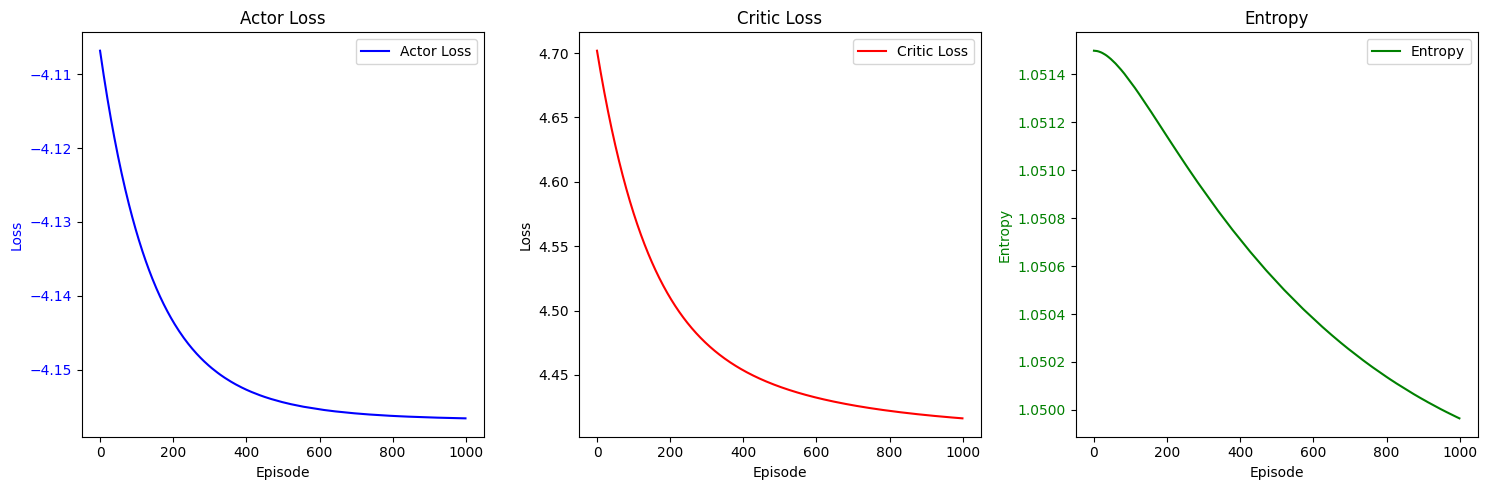

In [32]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot actor loss on the primary y-axis of the first subplot
ax1.plot(a_losses, label='Actor Loss', color='b')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Loss', color='b')
ax1.set_title('Actor Loss')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis sharing the same x-axis for the first subplot
ax3.plot(a_entropies, label='Entropy', color='g')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Entropy', color='g')
ax3.set_title('Entropy')
ax3.tick_params(axis='y', labelcolor='g')

# # Combine legends for both y-axes of the first subplot
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax3.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Plot critic loss on the second subplot
ax2.plot(c_losses, label='Critic Loss', color='r')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Loss')
ax2.set_title('Critic Loss')
ax2.legend()
ax1.legend()
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure with subplots
plt.show()


# Analysis of results

We can look at the policies $\pi_{\theta_A}$ and $\pi_{\theta_C}$ obtained after training to compare it with classic RSA, as welle as the value of the objective function = -loss of the critic.

In [33]:
sac
print("critic policy : ", sac.critic.probs)
print("actor policy : ", sac.actor.probs)
print(T)

critic policy :  tensor([[3.7626e-01, 1.8692e-01, 2.5227e-01, 8.4078e-45, 1.8454e-01],
        [4.6160e-01, 2.2882e-01, 3.0959e-01, 1.1210e-44, 1.1210e-44],
        [1.8217e-44, 5.0372e-01, 1.8217e-44, 1.8217e-44, 4.9628e-01],
        [1.8217e-44, 1.8217e-44, 1.8217e-44, 6.6721e-01, 3.3279e-01],
        [8.4078e-45, 1.8970e-01, 2.5626e-01, 3.6676e-01, 1.8728e-01]],
       grad_fn=<CatBackward0>)
actor policy :  tensor([[4.8956e-01, 2.3619e-01, 3.2847e-01, 1.8217e-44, 2.3216e-01],
        [5.1044e-01, 2.4549e-01, 3.4223e-01, 1.8217e-44, 9.8091e-45],
        [1.8217e-44, 2.8164e-01, 1.2612e-44, 1.8217e-44, 2.7647e-01],
        [1.8217e-44, 9.8091e-45, 1.2612e-44, 5.2990e-01, 2.5873e-01],
        [1.8217e-44, 2.3668e-01, 3.2930e-01, 4.7010e-01, 2.3264e-01]],
       grad_fn=<CatBackward0>)
tensor([[1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1.]])


**SAC-RSA model does not perfectly match RSA model**. This is because we used a different algorithm and even when trying to maximize the same objective function, the results may be different because those two methods does not converge to an global optimum.